# TESS Atlas fit for TOI 461

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 461.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-461.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-461.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-461.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 461

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 461 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

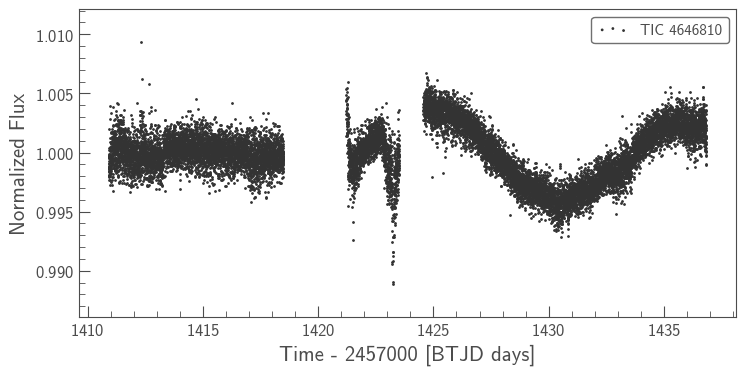

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -35460.22764629885 -> -24388.898355804995


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -22131.268878938296 -> -22073.4061116738


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -22073.4061116738 -> -22029.173159998194


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -22029.173159998194 -> -22027.698458823736


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -22027.698458823736 -> -22027.018184425193


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -22027.018184425193 -> -22017.230330201597


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -22017.230330201597 -> -22009.636130238185


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -22009.636130238185 -> -22009.636130238185


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -22009.636130238185 -> -22009.636130238185


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -22009.636130238185 -> -22009.636130238185


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -22009.636130238185 -> -22009.636130238185


optimizing logp for variables: ['mean', 'rb_radiusimpact__']
message: Optimization terminated successfully.
logp: -22009.636130238185 -> -22009.636130238185


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -22009.636130238185 -> -22009.636130238185


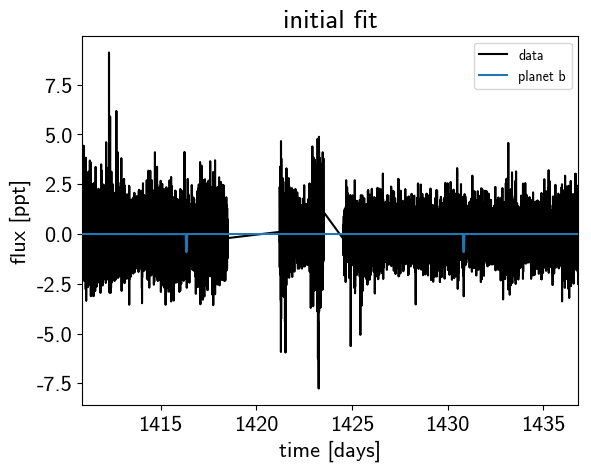

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   7%|▋         | 7/104 [00:00<00:04, 23.13draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:10,  9.41draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:14,  6.55draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:16,  5.43draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:18,  4.87draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:18,  4.61draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:19,  4.33draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:19,  4.19draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:19,  4.13draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:18,  4.23draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:18,  4.24draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:17,  4.18draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:17,  4.26draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:16,  4.35draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:15,  4.40draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:15,  4.29draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:08<00:16,  4.05draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:08<00:15,  4.13draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:08<00:13,  4.49draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:09<00:14,  4.26draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:09<00:13,  4.46draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:09<00:13,  4.30draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:09<00:12,  4.53draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:09<00:13,  4.21draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:10<00:12,  4.54draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:10<00:12,  4.50draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:10<00:12,  4.21draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:11<00:10,  4.86draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:11<00:13,  3.90draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:11<00:12,  3.96draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:11<00:12,  4.01draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:12<00:12,  3.78draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:12<00:11,  3.94draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:12<00:13,  3.46draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:13<00:11,  3.97draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:13<00:11,  3.78draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:13<00:10,  3.96draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:13<00:11,  3.65draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:14<00:10,  3.75draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:14<00:14,  2.78draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:14<00:11,  3.52draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:14<00:09,  4.22draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:15<00:08,  4.33draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:15<00:09,  3.96draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:15<00:09,  3.77draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:15<00:08,  4.13draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:16<00:08,  3.78draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:16<00:07,  4.24draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:16<00:08,  3.74draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:16<00:06,  4.52draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:17<00:07,  3.77draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:17<00:07,  3.58draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:17<00:06,  4.26draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:18<00:07,  3.52draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:18<00:06,  3.75draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:18<00:06,  3.81draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:18<00:07,  3.28draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:19<00:06,  3.44draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:19<00:05,  3.53draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:19<00:06,  3.30draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:19<00:04,  4.00draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:20<00:05,  3.39draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:20<00:04,  3.96draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:20<00:04,  3.72draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:20<00:03,  4.41draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:21<00:02,  4.74draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:21<00:03,  4.02draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:21<00:02,  4.70draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:21<00:02,  3.92draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:22<00:02,  3.99draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:22<00:02,  4.04draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:22<00:02,  3.37draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:23<00:01,  3.43draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:23<00:01,  3.44draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:24<00:00,  3.59draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:26<00:00,  1.30draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:26<00:00,  1.68draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:06, 15.77draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:08, 11.55draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:15,  5.97draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:19,  4.71draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:18,  5.03draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:21,  4.11draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:18,  4.78draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:22,  3.97draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:19,  4.50draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:24,  3.54draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:18,  4.50draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:24,  3.45draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:22,  3.55draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:22,  3.53draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:18,  4.21draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:21,  3.64draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:05<00:18,  4.22draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:05<00:20,  3.69draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:05<00:17,  4.33draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:18,  3.86draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:18,  3.85draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:18,  3.70draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:17,  3.82draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:08<00:15,  4.27draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:15,  4.06draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:08<00:14,  4.38draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:08<00:18,  3.37draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:09<00:16,  3.66draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:09<00:15,  3.79draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:17,  3.37draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:10<00:14,  4.00draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:10<00:15,  3.52draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:10<00:15,  3.61draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:10<00:13,  4.08draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:11<00:12,  4.03draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:12<00:12,  3.87draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:12<00:11,  3.99draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:13<00:11,  3.76draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:13<00:11,  3.78draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:14<00:10,  3.88draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:14<00:08,  4.75draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:14<00:09,  3.87draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:15<00:08,  4.29draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:15<00:08,  4.06draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:15<00:08,  4.11draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:15<00:09,  3.60draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:16<00:08,  4.04draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:16<00:09,  3.42draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:16<00:07,  4.21draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:17<00:09,  3.17draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:17<00:08,  3.37draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:17<00:07,  3.70draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:18<00:08,  2.96draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:18<00:07,  3.32draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:18<00:07,  3.15draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:19<00:06,  3.70draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:19<00:06,  3.56draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:19<00:05,  3.85draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:19<00:05,  3.92draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:20<00:04,  4.09draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:20<00:03,  4.19draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:20<00:03,  4.77draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:21<00:03,  3.57draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:21<00:03,  3.62draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:22<00:02,  3.78draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:22<00:02,  3.71draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:22<00:02,  3.98draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:23<00:01,  3.88draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:23<00:01,  3.32draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:24<00:01,  3.24draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:24<00:01,  2.74draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:25<00:00,  2.48draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:25<00:00,  1.94draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:26<00:00,  1.46draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<00:39,  5.12draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<00:39,  5.06draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:00<00:30,  6.45draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<00:50,  3.95draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:01<00:43,  4.49draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:36,  5.21draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:02<00:28,  6.58draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:02<00:27,  6.69draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:02<00:22,  8.09draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:02<00:19,  9.62draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:02<00:17, 10.55draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:03<00:23,  7.54draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:03<00:20,  8.82draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:03<00:15, 11.45draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:03<00:13, 13.09draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:04<00:14, 11.33draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:04<00:17,  9.59draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:04<00:14, 11.64draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:04<00:18,  8.60draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:05<00:24,  6.54draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:05<00:22,  6.87draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:05<00:19,  7.85draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:05<00:16,  9.56draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:06<00:19,  7.60draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:06<00:18,  7.90draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:06<00:17,  8.15draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:06<00:19,  7.52draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:07<00:18,  7.60draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:07<00:23,  6.03draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:07<00:21,  6.58draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:07<00:17,  7.94draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:07<00:14,  9.67draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:08<00:14,  9.30draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:08<00:12, 10.77draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:08<00:15,  8.27draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:08<00:13,  9.40draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:09<00:19,  6.42draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:09<00:16,  7.71draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:09<00:14,  8.31draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:10<00:19,  6.13draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:10<00:18,  6.38draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:10<00:21,  5.38draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:10<00:19,  5.84draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:11<00:16,  6.83draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:11<00:19,  5.82draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:11<00:23,  4.69draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:11<00:20,  5.24draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:12<00:18,  5.76draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:12<00:14,  7.23draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:12<00:15,  6.55draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:12<00:18,  5.41draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:13<00:21,  4.68draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:13<00:21,  4.54draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:13<00:20,  4.65draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:14<00:16,  5.90draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:14<00:14,  6.21draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:14<00:13,  7.00draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:14<00:12,  7.24draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:14<00:11,  7.61draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:14<00:12,  6.96draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:14<00:11,  7.36draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:15<00:13,  6.27draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:15<00:10,  8.08draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:15<00:13,  6.07draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:15<00:12,  6.24draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:16<00:13,  6.04draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:16<00:10,  7.45draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:16<00:09,  7.99draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:16<00:07,  9.37draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:17<00:09,  7.55draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:17<00:06,  9.94draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:17<00:05, 11.75draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:17<00:06, 10.31draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:17<00:04, 12.35draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:17<00:03, 14.65draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:18<00:03, 13.82draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:18<00:03, 12.98draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:18<00:03, 14.73draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:18<00:03, 12.22draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:18<00:03, 13.59draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:19<00:03, 12.49draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:19<00:03, 11.32draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:19<00:02, 13.33draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:19<00:02, 12.99draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:19<00:01, 16.64draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:20<00:02,  9.27draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:20<00:02,  8.14draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:21<00:03,  6.84draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:21<00:03,  5.62draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:22<00:05,  3.16draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:22<00:05,  3.15draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:22<00:04,  3.80draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:22<00:03,  4.38draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:23<00:02,  4.55draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:23<00:02,  4.73draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:24<00:03,  3.32draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:24<00:02,  3.77draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:24<00:01,  4.55draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:25<00:01,  3.26draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:25<00:00,  3.78draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:25<00:00,  7.86draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:08, 47.16draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:16, 24.67draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:00<00:19, 20.04draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:21, 17.99draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:00<00:18, 21.00draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:00<00:15, 24.65draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:00<00:13, 28.48draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:01<00:14, 26.57draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:01<00:15, 24.22draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:01<00:14, 25.14draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:01<00:14, 24.49draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:01<00:13, 27.51draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:01<00:12, 28.68draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:01<00:11, 30.81draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:01<00:10, 34.18draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:02<00:09, 37.75draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:02<00:08, 39.57draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:02<00:08, 41.34draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:02<00:07, 42.52draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:02<00:07, 44.01draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:02<00:07, 42.86draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:02<00:07, 43.65draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:02<00:06, 45.66draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:03<00:06, 44.66draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:03<00:06, 46.59draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:03<00:07, 40.06draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:03<00:06, 45.25draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:03<00:06, 45.04draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:03<00:07, 37.17draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:03<00:07, 37.14draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:03<00:06, 42.71draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:04<00:06, 41.00draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:04<00:06, 37.49draws/s]

Sampling 2 chains:  40%|████      | 162/404 [00:04<00:06, 37.14draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [00:04<00:05, 40.20draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:04<00:05, 42.91draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:04<00:04, 46.85draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:04<00:04, 50.07draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:04<00:04, 48.14draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:05<00:04, 50.61draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:05<00:03, 51.54draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [00:05<00:03, 53.28draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:05<00:03, 52.34draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:05<00:03, 51.73draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:05<00:03, 55.95draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:05<00:02, 60.34draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:05<00:02, 60.41draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [00:06<00:02, 56.17draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [00:06<00:02, 50.42draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [00:06<00:03, 42.23draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:06<00:03, 43.09draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:06<00:02, 48.47draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:06<00:02, 52.73draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:06<00:01, 58.12draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:06<00:01, 60.41draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:07<00:01, 62.78draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:07<00:01, 62.79draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:07<00:01, 62.84draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:07<00:01, 63.80draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:07<00:01, 66.84draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:07<00:00, 66.12draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [00:07<00:00, 66.05draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [00:07<00:00, 68.28draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [00:07<00:00, 68.24draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:08<00:00, 58.24draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:08<00:00, 54.10draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [00:08<00:00, 56.37draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:08<00:00, 60.82draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:08<00:00, 58.43draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:08<00:00, 46.60draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<00:17, 44.62draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<00:18, 42.15draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:00<00:17, 44.22draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:00<00:17, 45.35draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:00<00:21, 35.85draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:00<00:20, 37.15draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:00<00:19, 38.99draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:00<00:20, 37.19draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:01<00:22, 33.25draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:01<00:20, 36.40draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:01<00:17, 42.08draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:01<00:20, 35.91draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:01<00:19, 37.32draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:01<00:19, 38.04draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:01<00:18, 39.06draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:02<00:18, 39.36draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:02<00:18, 38.03draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:02<00:21, 33.29draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:02<00:21, 33.32draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:02<00:22, 31.04draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:02<00:20, 35.02draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:02<00:19, 36.08draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:02<00:16, 42.18draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:03<00:15, 45.04draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:03<00:14, 45.62draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:03<00:15, 42.96draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:03<00:15, 43.54draws/s]

Sampling 2 chains:  18%|█▊        | 143/804 [00:03<00:13, 48.31draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:03<00:12, 53.12draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:03<00:11, 54.69draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:03<00:10, 59.76draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:03<00:10, 61.60draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:04<00:10, 62.32draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:04<00:09, 63.01draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:04<00:10, 57.51draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:04<00:10, 55.67draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:04<00:13, 43.57draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:04<00:12, 45.65draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [00:04<00:12, 46.45draws/s]

Sampling 2 chains:  28%|██▊       | 223/804 [00:04<00:11, 50.63draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:05<00:10, 52.92draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:05<00:10, 51.82draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:05<00:16, 33.43draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:05<00:17, 32.55draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:05<00:17, 32.12draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:05<00:16, 32.57draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:06<00:16, 33.35draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:06<00:13, 39.19draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:06<00:12, 42.35draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [00:06<00:11, 44.29draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [00:06<00:10, 50.21draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:06<00:08, 57.63draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [00:06<00:08, 58.62draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:06<00:08, 57.19draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [00:06<00:07, 62.76draws/s]

Sampling 2 chains:  41%|████      | 327/804 [00:07<00:07, 65.36draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:07<00:07, 66.43draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [00:07<00:07, 59.05draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [00:07<00:07, 63.26draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:07<00:06, 65.83draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:07<00:06, 65.40draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:07<00:07, 60.68draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:07<00:07, 56.89draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:08<00:07, 56.14draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:08<00:07, 55.60draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [00:08<00:08, 48.58draws/s]

Sampling 2 chains:  50%|█████     | 403/804 [00:08<00:08, 48.59draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [00:08<00:07, 50.94draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:08<00:06, 55.89draws/s]

Sampling 2 chains:  53%|█████▎    | 424/804 [00:08<00:06, 55.89draws/s]

Sampling 2 chains:  54%|█████▎    | 431/804 [00:08<00:06, 59.29draws/s]

Sampling 2 chains:  55%|█████▍    | 439/804 [00:09<00:05, 64.00draws/s]

Sampling 2 chains:  55%|█████▌    | 446/804 [00:09<00:05, 60.77draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:09<00:05, 60.03draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [00:09<00:05, 64.08draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:09<00:05, 62.52draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:09<00:05, 55.42draws/s]

Sampling 2 chains:  60%|█████▉    | 481/804 [00:09<00:06, 52.25draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:09<00:05, 53.86draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [00:09<00:05, 53.94draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [00:10<00:05, 57.51draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [00:10<00:05, 53.21draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:10<00:05, 54.91draws/s]

Sampling 2 chains:  65%|██████▍   | 520/804 [00:10<00:04, 58.20draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:10<00:04, 61.97draws/s]

Sampling 2 chains:  67%|██████▋   | 535/804 [00:10<00:04, 59.82draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:10<00:04, 59.65draws/s]

Sampling 2 chains:  68%|██████▊   | 549/804 [00:10<00:04, 62.24draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:11<00:04, 61.98draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:11<00:04, 58.96draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:11<00:03, 60.75draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:11<00:03, 60.36draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:11<00:03, 59.57draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:11<00:03, 53.89draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:11<00:03, 53.62draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:11<00:04, 48.69draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:12<00:04, 45.00draws/s]

Sampling 2 chains:  76%|███████▋  | 614/804 [00:12<00:04, 43.99draws/s]

Sampling 2 chains:  77%|███████▋  | 619/804 [00:12<00:04, 42.69draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:12<00:04, 43.43draws/s]

Sampling 2 chains:  78%|███████▊  | 631/804 [00:12<00:03, 46.89draws/s]

Sampling 2 chains:  79%|███████▉  | 637/804 [00:12<00:03, 46.37draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [00:12<00:03, 48.95draws/s]

Sampling 2 chains:  81%|████████  | 650/804 [00:12<00:03, 49.62draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:13<00:02, 50.05draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:13<00:02, 48.78draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [00:13<00:02, 50.81draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:13<00:02, 55.37draws/s]

Sampling 2 chains:  85%|████████▍ | 683/804 [00:13<00:02, 56.74draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:13<00:02, 56.02draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [00:13<00:01, 59.35draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:13<00:01, 57.50draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:13<00:01, 57.09draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:14<00:01, 57.46draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [00:14<00:01, 57.67draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [00:14<00:01, 53.87draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:14<00:01, 52.61draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [00:14<00:01, 54.25draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [00:14<00:01, 52.97draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [00:14<00:00, 58.45draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:14<00:00, 59.71draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:14<00:00, 60.00draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [00:15<00:00, 49.71draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [00:15<00:00, 44.35draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [00:15<00:00, 38.88draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:15<00:00, 37.87draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [00:15<00:00, 36.65draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [00:16<00:00, 24.21draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:16<00:00, 22.62draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<01:23, 52.85draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<01:24, 51.80draws/s]

Sampling 2 chains:   0%|          | 15/4404 [00:00<01:47, 40.90draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:00<02:01, 36.15draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:00<02:09, 33.93draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:00<01:58, 37.07draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:00<01:52, 38.73draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:00<01:54, 38.04draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:00<01:35, 45.81draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:01<01:24, 51.50draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:01<01:30, 48.19draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:01<01:32, 46.91draws/s]

Sampling 2 chains:   2%|▏         | 70/4404 [00:01<01:41, 42.60draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:01<01:28, 48.76draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:01<01:17, 55.56draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:01<01:21, 53.01draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:02<01:15, 56.82draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:02<01:08, 62.33draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:02<01:11, 60.20draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:02<01:08, 62.08draws/s]

Sampling 2 chains:   3%|▎         | 131/4404 [00:02<01:08, 62.15draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:02<01:08, 61.91draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:02<01:06, 63.85draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:02<01:17, 55.01draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:02<01:16, 55.57draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:03<01:20, 52.98draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:03<01:26, 48.79draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:03<01:39, 42.49draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:03<01:44, 40.59draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:03<01:35, 44.26draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:03<01:28, 47.54draws/s]

Sampling 2 chains:   5%|▍         | 200/4404 [00:03<01:23, 50.50draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:03<01:22, 51.17draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:04<01:13, 57.09draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:04<01:15, 55.71draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:04<01:26, 48.50draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:04<01:25, 48.61draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:04<01:26, 48.18draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:04<01:25, 48.58draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:04<01:25, 48.60draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:04<01:21, 50.97draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:05<01:19, 51.94draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:05<01:13, 55.89draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:05<01:22, 50.03draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:05<01:25, 47.99draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:05<01:32, 44.52draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:05<01:30, 45.52draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:05<01:30, 45.33draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:05<01:30, 45.37draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:06<01:24, 48.37draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [00:06<01:26, 47.35draws/s]

Sampling 2 chains:   7%|▋         | 320/4404 [00:06<01:19, 51.59draws/s]

Sampling 2 chains:   7%|▋         | 328/4404 [00:06<01:11, 57.34draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:06<01:06, 61.09draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:06<01:07, 60.38draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:06<01:14, 54.70draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:06<01:15, 53.82draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:06<01:14, 54.45draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:07<01:08, 58.55draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:07<01:07, 59.68draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:07<01:06, 60.46draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:07<01:04, 62.06draws/s]

Sampling 2 chains:   9%|▉         | 400/4404 [00:07<01:08, 58.20draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:07<01:10, 56.78draws/s]

Sampling 2 chains:   9%|▉         | 415/4404 [00:07<01:08, 58.63draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:07<01:04, 61.69draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:08<00:55, 70.93draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:08<00:59, 66.34draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [00:08<01:04, 61.32draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [00:08<00:59, 66.57draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:08<00:55, 70.92draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:08<01:01, 63.77draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:08<01:09, 56.73draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:09<01:14, 52.39draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:09<01:19, 49.36draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:09<01:25, 45.38draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:09<01:23, 46.51draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:09<01:15, 51.69draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:09<01:09, 56.18draws/s]

Sampling 2 chains:  12%|█▏        | 531/4404 [00:09<01:07, 57.07draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:09<01:01, 63.00draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:10<00:57, 66.54draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:10<00:57, 67.39draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:10<00:56, 68.14draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [00:10<00:54, 69.88draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:10<00:55, 68.69draws/s]

Sampling 2 chains:  13%|█▎        | 586/4404 [00:10<00:58, 65.55draws/s]

Sampling 2 chains:  13%|█▎        | 593/4404 [00:10<01:01, 62.39draws/s]

Sampling 2 chains:  14%|█▎        | 602/4404 [00:10<00:56, 67.28draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [00:10<00:57, 65.99draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:11<00:57, 65.55draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:11<01:06, 56.57draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [00:11<01:04, 58.07draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [00:11<01:01, 61.03draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:11<00:59, 63.01draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:11<00:52, 70.87draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [00:11<00:52, 71.72draws/s]

Sampling 2 chains:  15%|█▌        | 671/4404 [00:11<00:59, 62.54draws/s]

Sampling 2 chains:  15%|█▌        | 678/4404 [00:12<01:04, 57.83draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:12<01:04, 58.04draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [00:12<00:59, 62.75draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [00:12<00:58, 63.35draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [00:12<01:01, 60.56draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:12<00:54, 67.15draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:12<00:51, 71.22draws/s]

Sampling 2 chains:  17%|█▋        | 735/4404 [00:12<00:52, 69.59draws/s]

Sampling 2 chains:  17%|█▋        | 744/4404 [00:12<00:49, 74.27draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [00:13<00:49, 73.67draws/s]

Sampling 2 chains:  17%|█▋        | 760/4404 [00:13<00:49, 73.13draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [00:13<00:49, 73.27draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [00:13<00:51, 70.40draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:13<00:59, 60.78draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [00:13<01:08, 52.70draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:13<01:13, 49.04draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [00:14<01:12, 49.54draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [00:14<01:09, 51.91draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [00:14<01:08, 52.59draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:14<01:07, 53.42draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [00:14<01:02, 57.30draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [00:14<00:59, 60.02draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [00:14<00:54, 65.45draws/s]

Sampling 2 chains:  19%|█▉        | 852/4404 [00:14<00:54, 65.11draws/s]

Sampling 2 chains:  20%|█▉        | 861/4404 [00:14<00:50, 70.67draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:15<00:52, 67.57draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [00:15<00:50, 69.47draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [00:15<00:51, 68.94draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [00:15<00:50, 69.77draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [00:15<00:51, 68.64draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [00:15<00:49, 71.29draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [00:15<00:46, 74.87draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [00:15<00:44, 78.19draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:15<00:42, 80.87draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [00:16<00:47, 73.10draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [00:16<00:46, 73.65draws/s]

Sampling 2 chains:  22%|██▏       | 962/4404 [00:16<00:47, 72.35draws/s]

Sampling 2 chains:  22%|██▏       | 971/4404 [00:16<00:44, 76.67draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [00:16<00:45, 74.63draws/s]

Sampling 2 chains:  22%|██▏       | 988/4404 [00:16<00:44, 76.27draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [00:16<00:50, 67.73draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [00:16<00:48, 70.39draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [00:16<00:50, 67.11draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [00:17<00:50, 66.75draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [00:17<00:51, 65.50draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [00:17<00:52, 64.44draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [00:17<00:53, 62.33draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [00:17<00:56, 59.32draws/s]

Sampling 2 chains:  24%|██▍       | 1056/4404 [00:17<00:53, 62.95draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [00:17<00:48, 69.08draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [00:17<00:46, 71.86draws/s]

Sampling 2 chains:  25%|██▍       | 1082/4404 [00:18<00:49, 66.45draws/s]

Sampling 2 chains:  25%|██▍       | 1089/4404 [00:18<00:50, 66.19draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [00:18<00:49, 66.50draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [00:18<00:49, 66.86draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [00:18<00:55, 59.52draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [00:18<00:54, 59.91draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [00:18<00:56, 58.17draws/s]

Sampling 2 chains:  26%|██▌       | 1130/4404 [00:18<00:59, 55.18draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [00:18<00:55, 58.44draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [00:19<00:52, 61.82draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [00:19<00:52, 61.72draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [00:19<00:53, 61.01draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [00:19<00:53, 60.17draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [00:19<00:59, 54.47draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [00:19<00:55, 58.21draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [00:19<00:53, 59.67draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [00:19<00:52, 61.34draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [00:20<00:54, 58.89draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [00:20<00:56, 56.19draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [00:20<00:58, 54.92draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [00:20<00:58, 54.04draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [00:20<00:57, 55.61draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [00:20<01:00, 52.08draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [00:20<01:03, 49.56draws/s]

Sampling 2 chains:  28%|██▊       | 1244/4404 [00:20<01:02, 50.34draws/s]

Sampling 2 chains:  28%|██▊       | 1250/4404 [00:21<01:10, 44.83draws/s]

Sampling 2 chains:  28%|██▊       | 1255/4404 [00:21<01:11, 43.82draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [00:21<01:04, 48.59draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [00:21<00:59, 52.59draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [00:21<01:00, 51.78draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [00:21<00:56, 55.29draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [00:21<00:53, 58.42draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [00:21<00:48, 64.26draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [00:21<00:48, 63.56draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [00:22<00:43, 71.28draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [00:22<00:47, 64.68draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [00:22<00:45, 67.11draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [00:22<00:48, 63.57draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [00:22<00:45, 66.66draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [00:22<00:45, 66.53draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [00:22<00:46, 66.07draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [00:22<00:41, 73.38draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [00:23<00:38, 78.95draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [00:23<00:37, 81.04draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [00:23<00:36, 82.43draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [00:23<00:40, 74.48draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [00:23<00:40, 73.79draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [00:23<00:39, 75.25draws/s]

Sampling 2 chains:  33%|███▎      | 1440/4404 [00:23<00:38, 77.20draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [00:23<00:50, 58.78draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [00:24<00:51, 57.28draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [00:24<00:57, 51.50draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [00:24<00:55, 53.22draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [00:24<00:53, 54.46draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [00:24<01:04, 45.33draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [00:24<01:01, 47.28draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [00:24<00:59, 48.74draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [00:25<01:03, 46.00draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [00:25<01:03, 45.53draws/s]

Sampling 2 chains:  34%|███▍      | 1510/4404 [00:25<01:03, 45.54draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [00:25<00:57, 49.90draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [00:25<01:00, 47.81draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [00:25<00:57, 49.81draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [00:25<00:52, 54.41draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [00:25<00:53, 53.56draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [00:25<00:51, 55.72draws/s]

Sampling 2 chains:  35%|███▌      | 1562/4404 [00:26<00:43, 65.28draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [00:26<00:42, 66.15draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [00:26<00:46, 61.11draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [00:26<00:44, 63.38draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [00:26<00:47, 58.75draws/s]

Sampling 2 chains:  36%|███▋      | 1599/4404 [00:26<00:46, 60.84draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [00:26<00:48, 57.29draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [00:26<00:48, 57.03draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [00:27<00:52, 52.96draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [00:27<00:52, 53.33draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [00:27<00:51, 53.54draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [00:27<00:52, 53.16draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [00:27<00:51, 53.87draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [00:27<00:49, 55.18draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [00:27<00:51, 53.84draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [00:27<00:46, 59.39draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [00:27<00:46, 59.34draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [00:28<00:44, 61.19draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [00:28<00:43, 62.85draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [00:28<00:44, 60.89draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [00:28<00:46, 58.50draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [00:28<00:46, 58.19draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [00:28<00:47, 56.44draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [00:28<00:48, 55.57draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [00:28<00:45, 59.38draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [00:29<00:45, 58.71draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [00:29<00:44, 60.37draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [00:29<00:43, 60.99draws/s]

Sampling 2 chains:  40%|███▉      | 1755/4404 [00:29<00:46, 56.90draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [00:29<00:44, 59.33draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [00:29<00:44, 59.42draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [00:29<00:44, 58.59draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [00:29<00:44, 58.79draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [00:29<00:44, 58.19draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [00:30<00:45, 57.91draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [00:30<00:43, 60.33draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [00:30<00:45, 56.45draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [00:30<00:41, 62.42draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [00:30<00:38, 66.41draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [00:30<00:45, 57.03draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [00:30<00:45, 56.92draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [00:30<00:44, 56.97draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [00:31<00:41, 60.87draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [00:31<00:40, 62.50draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [00:31<00:42, 59.48draws/s]

Sampling 2 chains:  43%|████▎     | 1878/4404 [00:31<00:43, 58.16draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [00:31<00:47, 52.64draws/s]

Sampling 2 chains:  43%|████▎     | 1890/4404 [00:31<00:49, 50.31draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [00:31<00:52, 47.97draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [00:31<00:54, 46.24draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [00:32<00:59, 42.07draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [00:32<00:56, 43.99draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [00:32<00:49, 50.49draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [00:32<00:47, 52.02draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [00:32<00:44, 54.97draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [00:32<00:46, 52.88draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [00:32<00:44, 54.81draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [00:32<00:41, 58.56draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [00:33<00:40, 60.22draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [00:33<00:39, 61.54draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [00:33<00:41, 58.02draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [00:33<00:41, 59.02draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [00:33<00:39, 61.79draws/s]

Sampling 2 chains:  45%|████▌     | 1996/4404 [00:33<00:38, 62.67draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [00:33<00:34, 70.11draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [00:33<00:34, 70.20draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [00:33<00:33, 70.64draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [00:34<00:35, 67.17draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [00:34<00:35, 67.11draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [00:34<00:39, 59.27draws/s]

Sampling 2 chains:  47%|████▋     | 2051/4404 [00:34<00:39, 60.25draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [00:34<00:43, 53.57draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [00:34<00:43, 53.58draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [00:34<00:46, 50.42draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [00:34<00:44, 52.56draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [00:35<00:45, 51.42draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [00:35<00:42, 54.14draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [00:35<00:36, 62.75draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [00:35<00:34, 66.84draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [00:35<00:32, 69.41draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [00:35<00:35, 65.08draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [00:35<00:34, 65.54draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [00:35<00:34, 66.50draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [00:35<00:35, 63.40draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [00:36<00:35, 64.15draws/s]

Sampling 2 chains:  49%|████▉     | 2161/4404 [00:36<00:32, 69.21draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [00:36<00:33, 67.61draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [00:36<00:38, 58.34draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [00:36<00:34, 64.73draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [00:36<00:34, 64.20draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [00:36<00:33, 66.40draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [00:36<00:30, 71.88draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [00:37<00:31, 69.49draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [00:37<00:31, 68.51draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [00:37<00:30, 70.83draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [00:37<00:30, 70.03draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [00:37<00:31, 67.89draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [00:37<00:31, 69.13draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [00:37<00:29, 72.99draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [00:37<00:28, 74.13draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [00:37<00:28, 75.25draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [00:38<00:30, 68.16draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [00:38<00:32, 65.60draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [00:38<00:31, 65.90draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [00:38<00:32, 64.63draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [00:38<00:36, 57.13draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [00:38<00:37, 56.09draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [00:38<00:35, 58.99draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [00:38<00:38, 53.52draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [00:39<00:37, 55.25draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [00:39<00:40, 50.70draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [00:39<00:35, 57.40draws/s]

Sampling 2 chains:  54%|█████▍    | 2370/4404 [00:39<00:39, 51.27draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [00:39<00:36, 54.91draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [00:39<00:35, 57.37draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [00:39<00:32, 62.21draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [00:39<00:29, 67.92draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [00:40<00:28, 69.56draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [00:40<00:28, 70.80draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [00:40<00:28, 69.92draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [00:40<00:27, 71.74draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [00:40<00:26, 75.26draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [00:40<00:24, 80.11draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [00:40<00:24, 79.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [00:40<00:24, 78.50draws/s]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [00:40<00:26, 72.88draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [00:41<00:26, 72.93draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [00:41<00:27, 69.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [00:41<00:27, 68.46draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [00:41<00:27, 68.80draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [00:41<00:29, 64.49draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [00:41<00:26, 69.81draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [00:41<00:27, 68.12draws/s]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [00:41<00:26, 69.92draws/s]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [00:41<00:25, 71.86draws/s]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [00:42<00:26, 69.73draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [00:42<00:27, 66.76draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [00:42<00:28, 65.32draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [00:42<00:25, 70.49draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [00:42<00:26, 68.91draws/s]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [00:42<00:26, 67.06draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [00:42<00:26, 68.76draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [00:42<00:26, 68.71draws/s]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [00:43<00:27, 63.80draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [00:43<00:29, 59.75draws/s]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [00:43<00:30, 58.67draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [00:43<00:32, 54.18draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [00:43<00:32, 54.63draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [00:43<00:31, 55.48draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [00:43<00:31, 55.21draws/s]

Sampling 2 chains:  61%|██████    | 2666/4404 [00:43<00:31, 54.38draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [00:44<00:30, 56.25draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [00:44<00:29, 58.00draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [00:44<00:29, 58.83draws/s]

Sampling 2 chains:  61%|██████    | 2694/4404 [00:44<00:28, 59.49draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [00:44<00:28, 60.46draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [00:44<00:28, 58.73draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [00:44<00:27, 60.85draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [00:44<00:27, 61.38draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [00:44<00:26, 62.65draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [00:45<00:26, 62.64draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [00:45<00:27, 59.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [00:45<00:25, 65.17draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [00:45<00:23, 69.46draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [00:45<00:23, 69.61draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [00:45<00:22, 71.72draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [00:45<00:22, 72.96draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [00:45<00:20, 77.79draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [00:45<00:20, 77.48draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [00:46<00:21, 72.68draws/s]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [00:46<00:22, 71.34draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [00:46<00:21, 72.81draws/s]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [00:46<00:21, 73.82draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [00:46<00:20, 76.79draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [00:46<00:19, 77.90draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [00:46<00:19, 80.37draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [00:46<00:20, 74.50draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [00:46<00:20, 75.84draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [00:47<00:19, 76.51draws/s]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [00:47<00:21, 69.61draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [00:47<00:21, 70.19draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [00:47<00:23, 63.39draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [00:47<00:23, 64.29draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [00:47<00:21, 67.79draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [00:47<00:21, 69.60draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [00:47<00:22, 64.03draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [00:48<00:24, 58.53draws/s]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [00:48<00:24, 58.70draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [00:48<00:23, 61.34draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [00:48<00:21, 65.43draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [00:48<00:21, 64.86draws/s]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [00:48<00:20, 70.48draws/s]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [00:48<00:19, 71.10draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [00:48<00:20, 67.86draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [00:48<00:19, 72.86draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [00:49<00:19, 69.67draws/s]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [00:49<00:19, 70.82draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [00:49<00:19, 70.70draws/s]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [00:49<00:18, 73.37draws/s]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [00:49<00:19, 70.61draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [00:49<00:20, 66.28draws/s]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [00:49<00:20, 63.81draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [00:49<00:19, 69.10draws/s]

Sampling 2 chains:  70%|███████   | 3091/4404 [00:50<00:19, 67.08draws/s]

Sampling 2 chains:  70%|███████   | 3098/4404 [00:50<00:19, 66.01draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [00:50<00:19, 66.15draws/s]

Sampling 2 chains:  71%|███████   | 3112/4404 [00:50<00:19, 66.33draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [00:50<00:19, 65.39draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [00:50<00:19, 65.83draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [00:50<00:19, 63.79draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [00:50<00:19, 65.43draws/s]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [00:50<00:19, 63.98draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [00:51<00:19, 65.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [00:51<00:21, 58.87draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [00:51<00:20, 60.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [00:51<00:19, 62.86draws/s]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [00:51<00:20, 58.92draws/s]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [00:51<00:20, 58.01draws/s]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [00:51<00:18, 63.67draws/s]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [00:51<00:16, 71.73draws/s]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [00:51<00:14, 79.45draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [00:52<00:14, 81.84draws/s]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [00:52<00:13, 86.95draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [00:52<00:12, 95.53draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [00:52<00:11, 99.24draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [00:52<00:13, 84.36draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [00:52<00:15, 73.63draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [00:52<00:15, 70.19draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [00:53<00:16, 68.68draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [00:53<00:15, 70.39draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [00:53<00:15, 70.18draws/s]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [00:53<00:17, 63.27draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [00:53<00:16, 65.75draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [00:53<00:14, 73.62draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [00:53<00:13, 76.30draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [00:53<00:13, 74.92draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [00:53<00:14, 70.69draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [00:54<00:13, 75.55draws/s]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [00:54<00:13, 74.13draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [00:54<00:13, 77.16draws/s]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [00:54<00:13, 75.30draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [00:54<00:13, 75.54draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [00:54<00:13, 71.40draws/s]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [00:54<00:13, 70.81draws/s]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [00:54<00:12, 75.76draws/s]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [00:54<00:12, 76.74draws/s]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [00:55<00:11, 81.50draws/s]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [00:55<00:12, 76.85draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [00:55<00:12, 75.27draws/s]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [00:55<00:13, 70.35draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [00:55<00:12, 71.17draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [00:55<00:14, 63.24draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [00:55<00:13, 64.65draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [00:55<00:12, 68.33draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [00:56<00:12, 70.36draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [00:56<00:13, 65.01draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [00:56<00:12, 66.76draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [00:56<00:14, 59.53draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [00:56<00:16, 51.44draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [00:56<00:15, 53.59draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [00:56<00:16, 50.80draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [00:57<00:15, 53.41draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [00:57<00:15, 53.85draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [00:57<00:13, 59.56draws/s]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [00:57<00:13, 61.90draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [00:57<00:12, 64.78draws/s]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [00:57<00:11, 66.97draws/s]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [00:57<00:11, 67.83draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [00:57<00:12, 63.95draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [00:57<00:11, 66.55draws/s]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [00:58<00:11, 64.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [00:58<00:11, 64.09draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [00:58<00:13, 55.18draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [00:58<00:13, 55.54draws/s]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [00:58<00:12, 60.86draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [00:58<00:10, 67.36draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [00:58<00:10, 70.99draws/s]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [00:58<00:10, 67.43draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [00:58<00:10, 68.78draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [00:59<00:10, 63.08draws/s]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [00:59<00:11, 61.18draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [00:59<00:12, 53.47draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [00:59<00:12, 52.49draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [00:59<00:13, 50.21draws/s]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [00:59<00:13, 48.96draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [00:59<00:12, 51.40draws/s]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [01:00<00:12, 52.93draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [01:00<00:11, 53.41draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [01:00<00:11, 55.39draws/s]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [01:00<00:10, 58.26draws/s]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [01:00<00:10, 58.53draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [01:00<00:09, 63.05draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [01:00<00:09, 63.99draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [01:00<00:11, 53.94draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [01:01<00:12, 48.56draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [01:01<00:11, 49.91draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [01:01<00:11, 50.97draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [01:01<00:11, 49.86draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [01:01<00:09, 57.81draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [01:01<00:09, 58.89draws/s]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [01:01<00:09, 58.06draws/s]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [01:01<00:10, 50.27draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [01:02<00:10, 48.94draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [01:02<00:10, 51.44draws/s]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [01:02<00:09, 55.19draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [01:02<00:09, 55.71draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [01:02<00:08, 60.12draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [01:02<00:08, 59.22draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [01:02<00:08, 57.26draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [01:02<00:08, 56.73draws/s]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [01:02<00:07, 63.52draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [01:03<00:07, 61.21draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [01:03<00:07, 65.85draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [01:03<00:06, 69.19draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [01:03<00:06, 69.43draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [01:03<00:06, 68.77draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [01:03<00:06, 66.29draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [01:03<00:06, 63.81draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [01:03<00:06, 64.08draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [01:03<00:06, 67.18draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [01:04<00:05, 72.61draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [01:04<00:05, 76.33draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [01:04<00:04, 76.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [01:04<00:04, 77.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [01:04<00:04, 79.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [01:04<00:04, 80.47draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [01:04<00:04, 82.92draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [01:04<00:03, 84.75draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [01:04<00:03, 85.64draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [01:05<00:03, 87.10draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [01:05<00:04, 73.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [01:05<00:04, 60.06draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [01:05<00:05, 56.33draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [01:05<00:05, 55.59draws/s]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [01:05<00:05, 53.76draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [01:05<00:04, 55.06draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [01:05<00:04, 59.80draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [01:06<00:04, 61.32draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [01:06<00:03, 67.65draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [01:06<00:03, 68.48draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [01:06<00:03, 71.88draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [01:06<00:03, 74.07draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [01:06<00:02, 74.89draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [01:06<00:02, 77.86draws/s]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [01:06<00:02, 73.56draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [01:06<00:02, 76.71draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [01:07<00:02, 74.61draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [01:07<00:02, 72.72draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [01:07<00:02, 71.32draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [01:07<00:02, 72.02draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [01:07<00:02, 66.03draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [01:07<00:02, 66.74draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [01:07<00:01, 66.59draws/s]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [01:07<00:01, 63.83draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [01:08<00:01, 66.94draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [01:08<00:01, 64.98draws/s]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [01:08<00:01, 61.91draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [01:08<00:01, 63.63draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [01:08<00:01, 59.76draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [01:08<00:01, 56.49draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [01:08<00:01, 57.71draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [01:08<00:01, 57.45draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [01:09<00:01, 59.06draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [01:09<00:01, 51.64draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [01:09<00:00, 60.38draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [01:09<00:00, 57.62draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [01:09<00:00, 62.73draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [01:09<00:00, 60.19draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [01:09<00:00, 64.09draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [01:09<00:00, 69.21draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [01:10<00:00, 62.86draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<00:21, 47.54draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<00:22, 43.92draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:00<00:20, 48.66draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:00<00:19, 50.41draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:00<00:25, 37.86draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:00<00:25, 37.48draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:00<00:24, 39.44draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:00<00:21, 44.45draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:01<00:18, 50.53draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:01<00:20, 46.73draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:01<00:21, 44.09draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:01<00:24, 38.12draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:01<00:20, 45.19draws/s]

Sampling 2 chains:   8%|▊         | 83/1004 [00:01<00:20, 43.87draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:01<00:20, 43.86draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:02<00:21, 42.80draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:02<00:22, 41.06draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:02<00:23, 38.25draws/s]

Sampling 2 chains:  11%|█         | 110/1004 [00:02<00:20, 44.26draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:02<00:18, 46.96draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:02<00:16, 52.48draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:02<00:14, 58.44draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:02<00:14, 61.70draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:02<00:13, 62.72draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:03<00:13, 61.35draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:03<00:13, 60.38draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:03<00:14, 55.78draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:03<00:17, 48.47draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:03<00:17, 46.34draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:03<00:16, 48.34draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:03<00:18, 43.53draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:04<00:17, 46.20draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:04<00:16, 49.22draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:04<00:15, 51.61draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:04<00:15, 51.60draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:04<00:14, 52.56draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:04<00:14, 55.14draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:04<00:13, 54.88draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:04<00:12, 61.29draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [00:05<00:12, 58.43draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:05<00:12, 57.19draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:05<00:12, 59.55draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:05<00:13, 54.54draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:05<00:14, 50.42draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:05<00:13, 54.03draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:05<00:12, 56.53draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:05<00:12, 57.01draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:06<00:14, 46.80draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:06<00:13, 50.45draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:06<00:13, 49.93draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [00:06<00:15, 44.87draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:06<00:17, 38.90draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:06<00:16, 40.78draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:06<00:15, 42.68draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [00:06<00:16, 40.52draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:07<00:16, 40.77draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [00:07<00:15, 41.85draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:07<00:14, 43.53draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:07<00:13, 47.05draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:07<00:13, 48.02draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [00:07<00:12, 48.79draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [00:07<00:12, 49.63draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [00:07<00:12, 47.41draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [00:08<00:14, 43.38draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [00:08<00:14, 40.98draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:08<00:13, 43.07draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [00:08<00:12, 45.87draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [00:08<00:11, 49.91draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:08<00:10, 55.25draws/s]

Sampling 2 chains:  43%|████▎     | 434/1004 [00:08<00:10, 55.82draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:08<00:10, 53.54draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [00:08<00:10, 55.07draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:09<00:10, 54.91draws/s]

Sampling 2 chains:  46%|████▌     | 461/1004 [00:09<00:09, 55.43draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:09<00:09, 54.80draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:09<00:09, 54.06draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:09<00:09, 53.59draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [00:09<00:09, 56.67draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [00:09<00:08, 60.10draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:09<00:08, 58.60draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [00:10<00:07, 63.21draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [00:10<00:07, 62.77draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [00:10<00:07, 63.00draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:10<00:06, 68.95draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [00:10<00:06, 70.41draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [00:10<00:06, 67.09draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:10<00:06, 67.15draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [00:10<00:07, 59.90draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [00:10<00:07, 55.15draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [00:11<00:09, 47.29draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [00:11<00:08, 49.26draws/s]

Sampling 2 chains:  59%|█████▉    | 590/1004 [00:11<00:07, 53.35draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [00:11<00:07, 54.08draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:11<00:07, 53.10draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [00:11<00:07, 50.89draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [00:11<00:07, 49.94draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [00:12<00:08, 46.57draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [00:12<00:07, 48.73draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [00:12<00:07, 49.40draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:12<00:07, 51.24draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [00:12<00:06, 55.21draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [00:12<00:06, 55.51draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [00:12<00:06, 52.93draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [00:12<00:06, 56.28draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [00:12<00:06, 51.50draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [00:13<00:06, 53.30draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:13<00:06, 51.13draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [00:13<00:05, 52.75draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [00:13<00:05, 53.68draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [00:13<00:05, 56.24draws/s]

Sampling 2 chains:  71%|███████   | 710/1004 [00:13<00:04, 60.10draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [00:13<00:04, 61.88draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [00:13<00:04, 61.99draws/s]

Sampling 2 chains:  73%|███████▎  | 732/1004 [00:13<00:04, 60.77draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [00:14<00:04, 61.11draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [00:14<00:04, 55.85draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [00:14<00:04, 55.18draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [00:14<00:04, 54.42draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [00:14<00:04, 52.34draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [00:14<00:04, 50.40draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [00:14<00:04, 49.06draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [00:14<00:04, 49.24draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [00:15<00:04, 48.44draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [00:15<00:04, 48.27draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [00:15<00:04, 48.15draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:15<00:04, 49.70draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [00:15<00:03, 50.37draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:15<00:04, 43.42draws/s]

Sampling 2 chains:  82%|████████▏ | 825/1004 [00:15<00:03, 47.47draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [00:15<00:03, 50.06draws/s]

Sampling 2 chains:  83%|████████▎ | 837/1004 [00:16<00:03, 48.85draws/s]

Sampling 2 chains:  84%|████████▍ | 843/1004 [00:16<00:03, 45.70draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [00:16<00:03, 48.99draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [00:16<00:02, 56.62draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:16<00:02, 57.13draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [00:16<00:02, 58.08draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [00:16<00:02, 61.46draws/s]

Sampling 2 chains:  88%|████████▊ | 888/1004 [00:16<00:02, 57.08draws/s]

Sampling 2 chains:  89%|████████▉ | 894/1004 [00:17<00:01, 57.12draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [00:17<00:02, 49.68draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [00:17<00:02, 47.66draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [00:17<00:02, 44.80draws/s]

Sampling 2 chains:  91%|█████████ | 916/1004 [00:17<00:02, 39.75draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [00:17<00:02, 35.12draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [00:17<00:02, 32.41draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [00:18<00:03, 21.51draws/s]

Sampling 2 chains:  93%|█████████▎| 932/1004 [00:18<00:03, 18.32draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [00:18<00:04, 16.95draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [00:18<00:03, 20.35draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [00:18<00:02, 23.80draws/s]

Sampling 2 chains:  95%|█████████▍| 949/1004 [00:19<00:02, 26.95draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [00:19<00:01, 28.79draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [00:19<00:01, 30.15draws/s]

Sampling 2 chains:  96%|█████████▌| 961/1004 [00:19<00:01, 30.34draws/s]

Sampling 2 chains:  96%|█████████▌| 965/1004 [00:19<00:01, 32.20draws/s]

Sampling 2 chains:  97%|█████████▋| 970/1004 [00:19<00:00, 35.15draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [00:19<00:00, 36.11draws/s]

Sampling 2 chains:  97%|█████████▋| 978/1004 [00:19<00:00, 33.30draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [00:20<00:00, 29.61draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [00:20<00:00, 29.67draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [00:20<00:00, 28.92draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [00:20<00:00, 31.74draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [00:20<00:00, 32.29draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:20<00:00, 34.87draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<00:55, 36.15draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<00:53, 37.00draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:00<00:55, 36.07draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:00<00:50, 39.28draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:00<00:45, 43.01draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:00<00:46, 42.33draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:00<00:48, 40.63draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:00<00:46, 42.40draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:01<00:45, 42.54draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:01<00:51, 38.20draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:01<00:48, 40.14draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:01<00:44, 43.61draws/s]

Sampling 2 chains:   3%|▎         | 68/2000 [00:01<00:40, 48.27draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:01<00:37, 50.97draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:01<00:39, 48.38draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:01<00:38, 49.95draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:02<00:36, 52.34draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:02<00:35, 53.87draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:02<00:36, 51.34draws/s]

Sampling 2 chains:   6%|▌         | 111/2000 [00:02<00:36, 51.97draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:02<00:34, 53.91draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:02<00:34, 55.08draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:02<00:35, 53.39draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:02<00:34, 53.75draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:02<00:32, 57.88draws/s]

Sampling 2 chains:   8%|▊         | 150/2000 [00:03<00:32, 56.97draws/s]

Sampling 2 chains:   8%|▊         | 156/2000 [00:03<00:33, 54.93draws/s]

Sampling 2 chains:   8%|▊         | 162/2000 [00:03<00:33, 55.66draws/s]

Sampling 2 chains:   8%|▊         | 168/2000 [00:03<00:36, 50.27draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:03<00:34, 52.66draws/s]

Sampling 2 chains:   9%|▉         | 180/2000 [00:03<00:33, 53.83draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:03<00:35, 51.09draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:03<00:33, 53.33draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:03<00:36, 49.70draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:04<00:38, 46.24draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:04<00:41, 42.97draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:04<00:40, 44.45draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:04<00:38, 46.61draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:04<00:35, 49.95draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:04<00:31, 56.23draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:04<00:31, 56.54draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:04<00:29, 58.86draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:05<00:29, 59.84draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:05<00:27, 62.09draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:05<00:27, 62.13draws/s]

Sampling 2 chains:  14%|█▍        | 277/2000 [00:05<00:28, 60.24draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:05<00:27, 62.46draws/s]

Sampling 2 chains:  15%|█▍        | 291/2000 [00:05<00:29, 57.56draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:05<00:27, 62.64draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:05<00:26, 63.09draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:06<00:27, 60.95draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:06<00:29, 56.24draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:06<00:32, 51.92draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:06<00:33, 49.37draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:06<00:31, 51.98draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:06<00:30, 53.63draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:06<00:30, 54.40draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:06<00:28, 57.41draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:06<00:27, 58.37draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:07<00:29, 55.75draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:07<00:27, 59.87draws/s]

Sampling 2 chains:  19%|█▉        | 388/2000 [00:07<00:25, 64.38draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:07<00:24, 66.69draws/s]

Sampling 2 chains:  20%|██        | 403/2000 [00:07<00:24, 64.22draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:07<00:25, 62.57draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:07<00:26, 59.18draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:07<00:27, 57.19draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:08<00:27, 56.18draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:08<00:27, 55.86draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:08<00:31, 50.23draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:08<00:32, 48.44draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:08<00:31, 49.13draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:08<00:32, 47.88draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:08<00:32, 47.31draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:08<00:30, 49.78draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:09<00:29, 52.33draws/s]

Sampling 2 chains:  24%|██▍       | 485/2000 [00:09<00:28, 53.40draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:09<00:28, 53.77draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:09<00:27, 54.62draws/s]

Sampling 2 chains:  25%|██▌       | 505/2000 [00:09<00:24, 60.31draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:09<00:27, 54.71draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:09<00:25, 58.80draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [00:09<00:25, 58.30draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:09<00:25, 58.18draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:10<00:25, 58.23draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:10<00:23, 62.81draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:10<00:25, 57.31draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:10<00:26, 53.56draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:10<00:26, 53.04draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:10<00:27, 52.57draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:10<00:25, 56.59draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:10<00:24, 57.55draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:10<00:25, 55.31draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:11<00:24, 56.73draws/s]

Sampling 2 chains:  30%|███       | 608/2000 [00:11<00:23, 58.67draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [00:11<00:22, 60.47draws/s]

Sampling 2 chains:  31%|███       | 623/2000 [00:11<00:21, 64.15draws/s]

Sampling 2 chains:  32%|███▏      | 630/2000 [00:11<00:21, 63.43draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [00:11<00:21, 64.67draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:11<00:20, 64.81draws/s]

Sampling 2 chains:  33%|███▎      | 651/2000 [00:11<00:22, 61.18draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:12<00:21, 61.19draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [00:12<00:24, 55.31draws/s]

Sampling 2 chains:  34%|███▎      | 672/2000 [00:12<00:23, 56.72draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [00:12<00:22, 58.88draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [00:12<00:24, 54.39draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:12<00:25, 50.68draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:12<00:25, 51.00draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:12<00:26, 49.76draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [00:13<00:24, 51.69draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [00:13<00:23, 54.98draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [00:13<00:22, 55.92draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [00:13<00:22, 56.45draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [00:13<00:22, 55.99draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [00:13<00:22, 55.16draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [00:13<00:22, 55.15draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [00:13<00:22, 54.99draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [00:13<00:22, 54.07draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [00:14<00:24, 51.27draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [00:14<00:23, 52.22draws/s]

Sampling 2 chains:  39%|███▉      | 780/2000 [00:14<00:22, 53.41draws/s]

Sampling 2 chains:  39%|███▉      | 786/2000 [00:14<00:26, 45.66draws/s]

Sampling 2 chains:  40%|███▉      | 792/2000 [00:14<00:25, 46.59draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [00:14<00:25, 46.34draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [00:14<00:24, 48.90draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:14<00:23, 50.80draws/s]

Sampling 2 chains:  41%|████      | 815/2000 [00:15<00:23, 50.41draws/s]

Sampling 2 chains:  41%|████      | 821/2000 [00:15<00:23, 49.39draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [00:15<00:21, 54.22draws/s]

Sampling 2 chains:  42%|████▏     | 835/2000 [00:15<00:21, 53.59draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:15<00:21, 54.79draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [00:15<00:19, 58.20draws/s]

Sampling 2 chains:  43%|████▎     | 857/2000 [00:15<00:19, 59.22draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [00:15<00:18, 61.71draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:15<00:17, 63.96draws/s]

Sampling 2 chains:  44%|████▍     | 878/2000 [00:16<00:17, 65.50draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [00:16<00:17, 62.34draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [00:16<00:17, 64.38draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [00:16<00:17, 63.74draws/s]

Sampling 2 chains:  45%|████▌     | 909/2000 [00:16<00:16, 66.39draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:16<00:16, 65.17draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [00:16<00:18, 59.74draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [00:16<00:17, 61.33draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [00:16<00:16, 63.27draws/s]

Sampling 2 chains:  47%|████▋     | 944/2000 [00:17<00:17, 60.56draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [00:17<00:18, 57.52draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [00:17<00:17, 57.90draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [00:17<00:18, 56.77draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [00:17<00:17, 57.53draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [00:17<00:18, 56.05draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [00:17<00:18, 55.86draws/s]

Sampling 2 chains:  49%|████▉     | 989/2000 [00:17<00:17, 56.94draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [00:18<00:17, 57.69draws/s]

Sampling 2 chains:  50%|█████     | 1002/2000 [00:18<00:17, 58.21draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [00:18<00:17, 56.61draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [00:18<00:17, 56.74draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [00:18<00:15, 62.62draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [00:18<00:16, 60.27draws/s]

Sampling 2 chains:  52%|█████▏    | 1037/2000 [00:18<00:15, 60.30draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [00:18<00:16, 58.64draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [00:18<00:16, 59.00draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [00:19<00:17, 54.55draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [00:19<00:16, 56.00draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [00:19<00:16, 56.14draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [00:19<00:16, 56.54draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [00:19<00:18, 50.71draws/s]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [00:19<00:18, 49.40draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:19<00:18, 48.84draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [00:19<00:19, 46.13draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:20<00:19, 46.73draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [00:20<00:18, 47.37draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [00:20<00:17, 49.70draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:20<00:17, 50.87draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [00:20<00:18, 46.42draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [00:20<00:18, 48.27draws/s]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [00:20<00:16, 51.10draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [00:20<00:16, 51.69draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [00:20<00:16, 51.73draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [00:21<00:15, 54.06draws/s]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [00:21<00:14, 56.74draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [00:21<00:14, 57.47draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [00:21<00:14, 56.23draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [00:21<00:14, 56.52draws/s]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [00:21<00:15, 52.60draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [00:21<00:14, 53.80draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [00:21<00:14, 55.46draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [00:21<00:15, 52.52draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [00:22<00:14, 52.48draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [00:22<00:14, 52.24draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [00:22<00:15, 50.35draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [00:22<00:14, 51.30draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [00:22<00:15, 49.92draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [00:22<00:15, 49.50draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [00:22<00:15, 47.91draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [00:22<00:14, 50.08draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [00:23<00:14, 52.31draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [00:23<00:13, 55.72draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [00:23<00:13, 54.32draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [00:23<00:12, 55.53draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [00:23<00:13, 54.00draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [00:23<00:12, 54.24draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [00:23<00:12, 55.48draws/s]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [00:23<00:13, 53.29draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [00:24<00:13, 49.31draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [00:24<00:13, 51.22draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [00:24<00:13, 51.61draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [00:24<00:12, 54.88draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [00:24<00:12, 54.71draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [00:24<00:13, 49.58draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [00:24<00:13, 47.87draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [00:24<00:13, 49.37draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [00:24<00:12, 51.76draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [00:25<00:11, 54.19draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [00:25<00:10, 58.33draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [00:25<00:10, 59.78draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [00:25<00:10, 59.14draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [00:25<00:10, 59.68draws/s]

Sampling 2 chains:  70%|███████   | 1407/2000 [00:25<00:10, 58.30draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [00:25<00:10, 58.38draws/s]

Sampling 2 chains:  71%|███████   | 1419/2000 [00:25<00:10, 55.19draws/s]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [00:26<00:10, 53.61draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [00:26<00:10, 54.35draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [00:26<00:10, 54.56draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [00:26<00:09, 55.55draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [00:26<00:09, 55.53draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [00:26<00:09, 55.10draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [00:26<00:09, 53.73draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [00:26<00:10, 52.10draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [00:26<00:09, 54.99draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [00:27<00:09, 56.86draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [00:27<00:08, 59.20draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [00:27<00:07, 65.16draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [00:27<00:07, 65.68draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [00:27<00:07, 62.66draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [00:27<00:07, 63.81draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [00:27<00:07, 64.65draws/s]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [00:27<00:07, 61.39draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [00:28<00:08, 56.76draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [00:28<00:07, 56.88draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [00:28<00:07, 60.15draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [00:28<00:07, 60.80draws/s]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [00:28<00:07, 61.14draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [00:28<00:06, 61.93draws/s]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [00:28<00:06, 64.07draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [00:28<00:06, 63.54draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [00:28<00:06, 58.41draws/s]

Sampling 2 chains:  80%|████████  | 1609/2000 [00:29<00:06, 60.35draws/s]

Sampling 2 chains:  81%|████████  | 1616/2000 [00:29<00:06, 62.16draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [00:29<00:05, 63.97draws/s]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [00:29<00:05, 63.07draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [00:29<00:05, 60.78draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [00:29<00:06, 58.17draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [00:29<00:05, 59.77draws/s]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [00:29<00:05, 60.12draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [00:30<00:05, 63.34draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [00:30<00:05, 61.04draws/s]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [00:30<00:04, 64.22draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [00:30<00:04, 65.19draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [00:30<00:04, 65.74draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [00:30<00:04, 63.97draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [00:30<00:04, 63.37draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [00:30<00:04, 64.22draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [00:30<00:04, 63.00draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [00:31<00:04, 61.91draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [00:31<00:04, 63.35draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [00:31<00:04, 62.21draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [00:31<00:03, 63.40draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [00:31<00:03, 62.04draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [00:31<00:03, 65.46draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [00:31<00:03, 60.86draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [00:31<00:03, 57.71draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [00:31<00:03, 58.32draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [00:32<00:03, 59.74draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [00:32<00:03, 60.94draws/s]

Sampling 2 chains:  91%|█████████ | 1812/2000 [00:32<00:02, 63.82draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [00:32<00:02, 61.33draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [00:32<00:02, 60.40draws/s]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [00:32<00:02, 62.08draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [00:32<00:02, 62.58draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [00:32<00:02, 66.70draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [00:33<00:02, 67.00draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [00:33<00:02, 62.50draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [00:33<00:02, 62.75draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [00:33<00:01, 64.84draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [00:33<00:01, 65.25draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [00:33<00:01, 58.27draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [00:33<00:01, 54.28draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [00:33<00:01, 50.66draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [00:34<00:01, 49.31draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [00:34<00:01, 48.11draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [00:34<00:01, 44.14draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [00:34<00:01, 40.93draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [00:34<00:01, 42.30draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [00:34<00:01, 39.36draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [00:34<00:01, 41.02draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [00:34<00:01, 42.84draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [00:35<00:01, 43.90draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [00:35<00:00, 45.54draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [00:35<00:00, 50.18draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [00:35<00:00, 51.49draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [00:35<00:00, 49.97draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [00:35<00:00, 51.33draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [00:35<00:00, 43.31draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [00:36<00:00, 29.05draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [00:36<00:00, 26.40draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:36<00:00, 55.00draws/s]

We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.002153,0.007630,0.000161,-0.012066,0.017180,2609.415217,1.000088
u__0,0.665357,0.461590,0.013037,0.000112,1.531881,1315.834990,0.999508
u__1,-0.000924,0.404049,0.010439,-0.787596,0.733384,1575.242664,0.999596
period__0,14.490033,0.006150,0.000152,14.478574,14.502300,1711.152211,0.999501
t0__0,1416.342467,0.003966,0.000105,1416.334203,1416.350157,1609.943137,0.999666
r__0,0.036052,0.007619,0.000311,0.024672,0.053094,572.661308,1.001882
b__0,0.918815,0.049316,0.001459,0.843902,1.000780,959.317910,1.004225
logs2,-0.440563,0.016581,0.000306,-0.470968,-0.406888,2614.635915,0.999701
r_star,0.771638,0.084860,0.001563,0.611838,0.935336,2301.750363,0.999848
logg_star,4.551737,0.182277,0.005084,4.198460,4.907667,1298.126097,0.999907


And then plot the posterior constraints on the folded transit models.

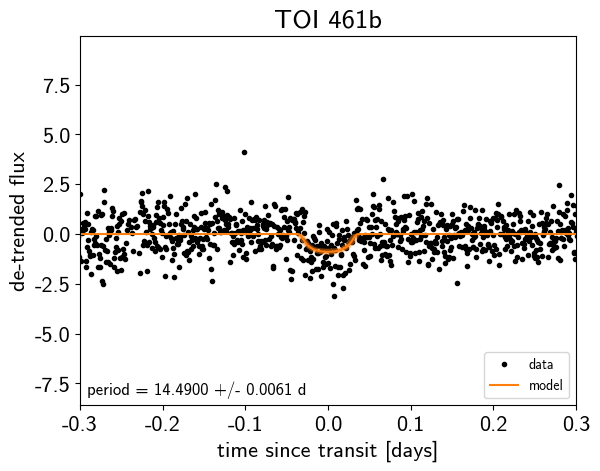

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

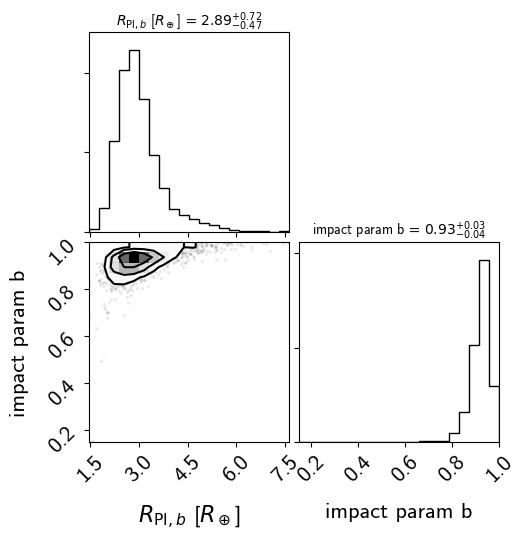

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

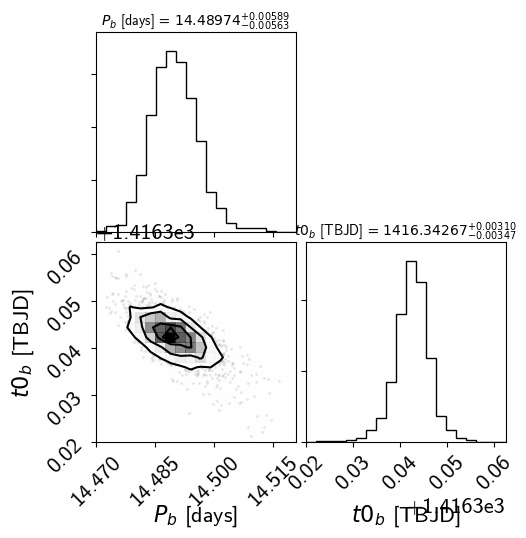

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

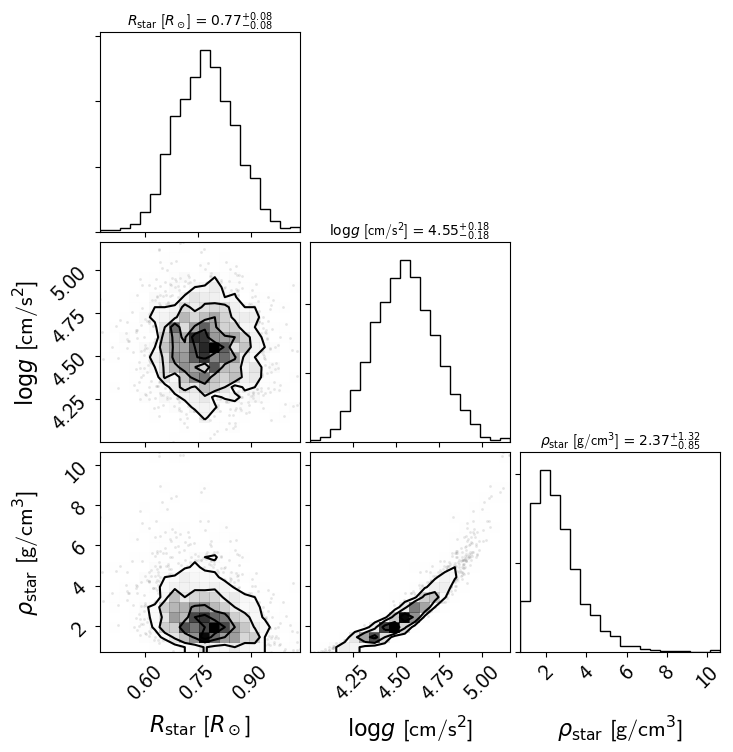

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3